In [1]:
!nvidia-smi

Tue Jun  6 09:49:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [1]:
import random
import cv2
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt

# Dataset
import tensorflow_datasets as tfds

# Utils
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
!pip install -q -U keras-tuner
import keras_tuner as kt

Load data set

In [19]:
# Multiple splits
(ds_train, train_dataset, val_dataset, test_dataset), ds_info = tfds.load('fashion_mnist', split=["train[0%:70%]", "train", "train[70%:]", "test"], shuffle_files=True, as_supervised=True, with_info=True)

# Traditional split
#(ds_train, val_dataset, test_dataset), ds_info = tfds.load('fashion_mnist', split=["train[0%:80%]", "train[80%:]", "test"], shuffle_files=True, as_supervised=True, with_info=True) # Original

# Small data set used for quick testing
#(ds_train, val_dataset, test_dataset), ds_info = tfds.load('fashion_mnist', split=["train[0%:1%]", "train[99%:]", "test[0:5%]"], shuffle_files=True, as_supervised=True, with_info=True)

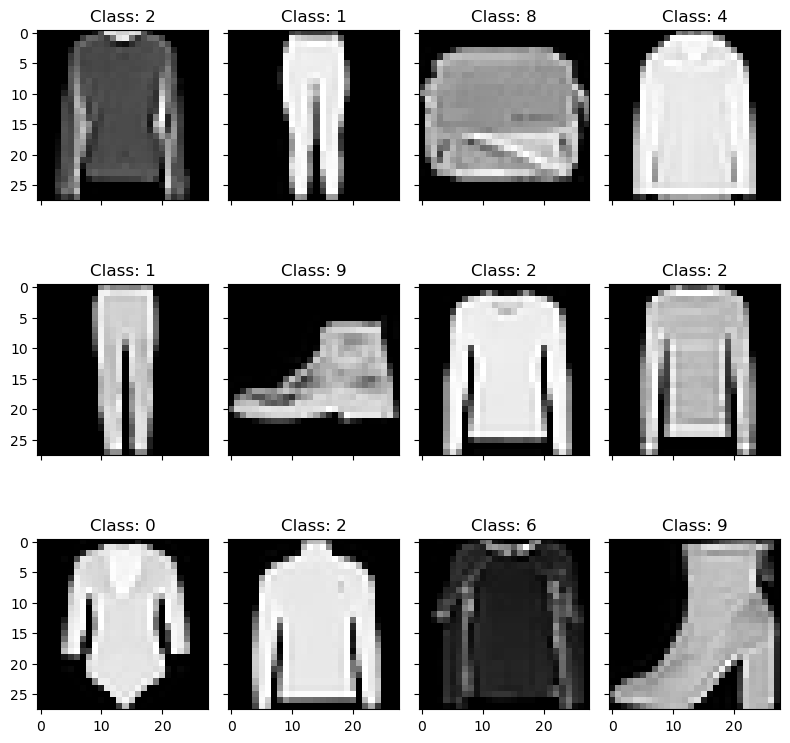

In [5]:
num_images = 12

# Plot examples of images
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(8, 8))
axs = axs.flatten()

for i, (image, label) in enumerate(ds_train.take(len(axs))):
    ax = axs[i]
    ax.imshow(image, cmap='gray')
    ax.set_title('Class: ' + str(label.numpy().astype("uint8")))

plt.tight_layout()

In [26]:
synthetic_data = tf.data.Dataset.load('/kaggle/input/data12345/synthetic_fashion_mnist_data/synthetic_fashion_mnist_data')

# Combine datasets
ds_train_extended = ds_train.concatenate(synthetic_data)

# Shuffle the combined dataset
ds_train_extended = ds_train_extended.shuffle(buffer_size=ds_train_extended.cardinality())
ds_train_extended = ds_train_extended.map(resize_and_convert2rgb, num_parallel_calls=AUTOTUNE)
ds_train_extended = ds_train_extended.cache()
ds_train_extended = ds_train_extended.batch(BATCH_SIZE)

Data preprocessing

In [4]:
def resize_and_convert2rgb(img, label):

    IMG_SIZE = 32

    # Convert image type
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)

    # Convert the grayscale image to RGB
    img = tf.image.grayscale_to_rgb(img)

    # Resize the image to (IMG_SIZE, IMG_SIZE)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    # NOTE: Rescaling is omitted as it is often part of the preprocesisng of a pretrained model


    return img, label

Preprocess data

In [5]:
AUTOTUNE   = tf.data.AUTOTUNE
BATCH_SIZE = 80

In [6]:
ds_train = ds_train.shuffle(len(ds_train))
ds_train = ds_train.map(resize_and_convert2rgb, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.batch(BATCH_SIZE)

In [29]:
val_dataset = val_dataset.map(resize_and_convert2rgb, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(60)

Data augmentation

---

TODO: Replace this with a Sequential model that applies all the same transformations. See:

- https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomBrightness



In [8]:
def data_augmenter():
  '''
    Create a Sequential model with data augmentation steps.
    Returns:
      tf.keras.Sequential
  '''

  data_augmentation = tf.keras.Sequential([
    tfl.RandomBrightness(0.2, value_range=(0,1)),
    tfl.RandomFlip("horizontal"),
    tfl.RandomRotation(0.2),
    tfl.RandomZoom(0.2),
    tfl.RandomTranslation(height_factor=0.2, width_factor=0.2),
  ])

  return data_augmentation

In [9]:
def convnext_fashion_model(fine_tune_at=175, optimizer='adam', learning_rate=0.001, lr_schedule='none', dropout=0.2, weight_decay=None):
  '''
    fine_tune_at - The starting layer for the fine tuning process. Resnet without top layers has 175 layers.
  '''
  #######################################################################
  # Local variables
  data_augmentation = data_augmenter()
  preprocess_input  = tf.keras.applications.convnext.preprocess_input
  num_classes       = 10          # Fashion MNIST specific
  input_shape       = (32,32,3) # Slightly smaller than the standard ConvNet

  # Load the pretrained model
  base_model = tf.keras.applications.convnext.ConvNeXtBase(input_shape=input_shape,
                                                  include_top=False,
                                                  weights='imagenet')
  
  # Freeze the base model by making it non trainable
  base_model.trainable = True

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  #######################################################################
  # MODEL DEFINITION

  inputs = tf.keras.Input(shape=input_shape)
  x      = data_augmentation(inputs)
  x      = preprocess_input(x)
  x      = base_model(x, training=False)
  x      = tfl.GlobalAveragePooling2D()(x)
  x      = tfl.Dropout(dropout)(x)

  prediction_layer = tfl.Dense(num_classes)

  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)
  
  # Set the learning rate scheduling
  if lr_schedule == 'none':
    l_rate = learning_rate
  elif lr_schedule == '94_exp_0_9':
    l_rate = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=94,
      decay_rate=0.9,
      staircase=False)
  elif lr_schedule == '94_step_0_9':
    l_rate = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=94,
      decay_rate=0.9,
      staircase=True)
  elif lr_schedule == '1880_exp_0_1':
    l_rate = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=1880,
      decay_rate=0.1,
      staircase=False)
  elif lr_schedule == '1880_step_0_1':
    l_rate = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=1880,
      decay_rate=0.1,
      staircase=True)
  elif lr_schedule == '2350_step_0_1':
    l_rate = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=2350,
      decay_rate=0.1,
      staircase=True)
  elif lr_schedule == 'piecewise_1':
    #boundaries = [37500, 56250, 67500] # Considering 750 steps per epoch, this is epoch 50, 75, and 90
    #boundaries = [18750, 28125, 33750] # Considering 350 steps per epoch, this is epoch 50, 75, and 90
    boundaries = [4700, 7050, 8460] # Considering 94 steps per epoch, this is epoch 50, 75, and 90
    values = [learning_rate, learning_rate*0.1, learning_rate*0.01, learning_rate*0.001]
    l_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
  else:
    l_rate = learning_rate

  # Set the optimizer based on the chosen hyperparameter value
  if optimizer == 'adam':
    optim = tf.keras.optimizers.Adam(learning_rate=l_rate, weight_decay=weight_decay)
  elif optimizer == 'nadam':
    optim = tf.keras.optimizers.Nadam(learning_rate=l_rate, weight_decay=weight_decay)
  elif optimizer == 'rmsprop':
    optim = tf.keras.optimizers.RMSprop(learning_rate=l_rate, weight_decay=weight_decay)
  elif optimizer == 'sgd':
    optim = tf.keras.optimizers.SGD(learning_rate=l_rate, weight_decay=weight_decay)
  elif optimizer == 'sgd_m_0_9':
    optim = tf.keras.optimizers.SGD(learning_rate=l_rate, momentum=0.9, weight_decay=weight_decay)
  elif optimizer == 'sgd_m_0_95':
    optim = tf.keras.optimizers.SGD(learning_rate=l_rate, momentum=0.95, weight_decay=weight_decay)
  else:
    optim = tf.keras.optimizers.Adam(learning_rate=l_rate, weight_decay=weight_decay)

  # Compile the model
  model.compile(optimizer=optim, loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

  return model

Resnet without top layers has 175 layers.

80% = 140 layers --> 142 is an activation so I think training after 142 could be reasonable

90% = 157.5 layers --> 157 is an activation so I think training after 157 could be reasonable

# Hyperparameter tuning

- https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=en
- https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams?hl=es-419

In [12]:
def tunable_convnext_fashion_model(hp=kt.HyperParameters()):
  '''
    Create a tunable version of the resnet50 fashion model
  '''
  # Define the hyperparam search space
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  hp_fine_tune_at  = hp.Choice('fine_tune_at' , values=[143])
  hp_optimizer     = hp.Choice('optimizer'    , values=['nadam', 'sgd_m_0_9', 'sgd_m_0_95'])
  
  hp_lr_schedule   = hp.Choice('lr_schedule'  , values=['94_step_0_9', 'piecewise_1'])
  #hp_lr_schedule   = hp.Choice('lr_schedule'  , values=['none', '250_exp_0_9', '250_step_0_9', '2500_exp_0_1', '2500_step_0_1', 'piecewise_1', '18750_step_0_1'])
  #hp_lr_schedule   = hp.Choice('lr_schedule'  , values=['none', '250_exp_0_9', '250_step_0_9', '2500_exp_0_1', '2500_step_0_1', 'custom_factor_0_1', 'custom_factor_0_2'])
  #hp_lr_schedule   = hp.Choice('lr_schedule'  , values=['custom_factor_0_1', 'custom_factor_0_2'])
  #hp_lr_schedule   = 'piecewise_1'

  hp_weight_decay   = hp.Choice('weight_decay', values=[1e-6, 1e-4, 0.0])
  hp_dropout_rate   = hp.Choice('dropout'      , [0.0, 0.1, 0.3,0.4])

  # Create the model with the selected hyperparams
  model = convnext_fashion_model(fine_tune_at=hp_fine_tune_at, optimizer=hp_optimizer, learning_rate=hp_learning_rate, lr_schedule=hp_lr_schedule, dropout=hp_dropout_rate, weight_decay=hp_weight_decay)

  return model

In [13]:
tuner_epochs = 10

In [14]:
tuner = kt.Hyperband(tunable_convnext_fashion_model,
                     objective='val_accuracy',
                     max_epochs=tuner_epochs,
                     factor=3,
                     overwrite=True,
                     directory='my_dir',
                     project_name='intro_to_kt')

350926856/350926856 [==============================] - 2s 0us/step


In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}
fine_tune_at (Choice)
{'default': 143, 'conditions': [], 'values': [143], 'ordered': True}
optimizer (Choice)
{'default': 'nadam', 'conditions': [], 'values': ['nadam', 'sgd_m_0_9', 'sgd_m_0_95'], 'ordered': False}
lr_schedule (Choice)
{'default': '94_step_0_9', 'conditions': [], 'values': ['94_step_0_9', 'piecewise_1'], 'ordered': False}
weight_decay (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 0.0001, 0.0], 'ordered': True}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.3, 0.4], 'ordered': True}


In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.00000001)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(ds_train, epochs=tuner_epochs, validation_data=val_dataset, callbacks=[stop_early, reduce_lr, tf.keras.callbacks.TensorBoard("/tmp/tb_logs")])



Trial 21 Complete [00h 05m 58s]
val_accuracy: 0.612500011920929

Best val_accuracy So Far: 0.738611102104187
Total elapsed time: 01h 52m 59s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
0.001             |0.001             |learning_rate
143               |143               |fine_tune_at
nadam             |nadam             |optimizer
94_step_0_9       |94_step_0_9       |lr_schedule
0                 |0.0001            |weight_decay
0.4               |0.1               |dropout
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/4
525/525 [==============================] - ETA: 0s - loss: 1.2921 - accuracy: 0.5481

Optional: Manually save best model

Note: 

- It is suppossed that the best model is saved throughout the training using the model checkpoint callback.

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

In [ ]:
# Get the best model
best_model = tuner.get_best_models(1)[0]

In [ ]:

best_model.save('/kaggle/working/resnet50_tuner.h5')

In [ ]:
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/resnet50_checkpoint.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

In [12]:
best_model_from_scratch = convnext_fashion_model(optimizer='nadam', learning_rate=0.001, fine_tune_at=143, lr_schedule='94_step_0_9', weight_decay=0.0001, dropout=0.1)

350926856/350926856 [==============================] - 2s 0us/step


In [15]:
initial_epochs = 10
history = best_model_from_scratch.fit(ds_train, epochs = initial_epochs, validation_data = val_dataset, callbacks=[stop_early, reduce_lr])

Epoch 1/10
525/525 [==============================] - 194s 192ms/step - loss: 1.2559 - accuracy: 0.5542 - val_loss: 0.8707 - val_accuracy: 0.6708 - lr: 5.9049e-04
Epoch 2/10
525/525 [==============================] - 94s 178ms/step - loss: 0.9191 - accuracy: 0.6657 - val_loss: 0.7951 - val_accuracy: 0.6998 - lr: 3.1381e-04
Epoch 3/10
525/525 [==============================] - 93s 178ms/step - loss: 0.8262 - accuracy: 0.6963 - val_loss: 0.7356 - val_accuracy: 0.7253 - lr: 1.8530e-04
Epoch 4/10
525/525 [==============================] - 90s 172ms/step - loss: 0.7698 - accuracy: 0.7177 - val_loss: 0.6582 - val_accuracy: 0.7508 - lr: 9.8477e-05
Epoch 5/10
525/525 [==============================] - 93s 177ms/step - loss: 0.7310 - accuracy: 0.7315 - val_loss: 0.7153 - val_accuracy: 0.7211 - lr: 5.8150e-05
Epoch 6/10
525/525 [==============================] - 93s 176ms/step - loss: 0.7067 - accuracy: 0.7392 - val_loss: 0.7026 - val_accuracy: 0.7262 - lr: 3.0903e-05
Epoch 7/10
525/525 [=======

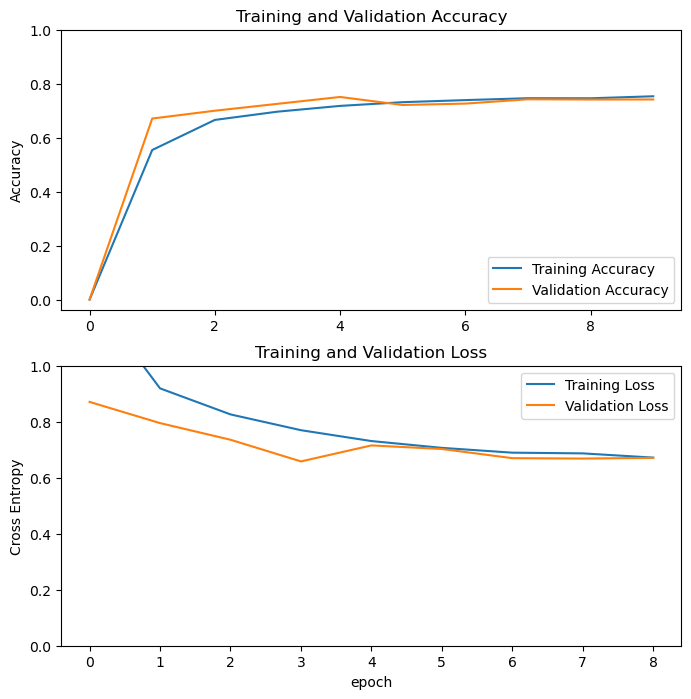

In [16]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()